In [43]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

import torch.nn.functional as F


In [5]:
# %cd /kaggle/working/
# !rm -rf Endoscopy-Image-Classification
# !git clone https://github.com/taindp98/Endoscopy-Image-Classification.git
# %cd './Endoscopy-Image-Classification/code'

In [44]:
from utils import show_batch, AverageMeter, show_grid, get_config, show_imgs
from fixmatch import FixMatch
from comatch import CoMatch
from supervised import SupLearning
from semiformer import SemiFormer
from dataset import get_data
from build import build_model

ImportError: cannot import name 'show_imgs'

In [45]:
def show_imgs(list_fnames):
    fig=plt.figure(figsize=(20,7))
    rows = 2
    columns = len(list_fnames)//rows
    k = 0
    for i in range(0, rows):
        for j in range(0, columns):
            img = cv2.imread(list_fnames[k])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
            fig.add_subplot(rows, columns, k+1)
            plt.imshow(img)
            plt.axis('off')
            k += 1

### Supervised Learning Re-produce

In [7]:
# config = get_config('./configs/kaggle_reproduce.yaml')
# df_anno = pd.read_csv(config['DATA']['ANNO'])
# df_unanno = None
# train_dl, valid_dl = get_data(config, df_anno, df_unanno, is_visual=True, is_reprod =True)
# model = build_model(config, is_pathology = True)

### Supervised Learning Abnormalities

In [8]:
# config = get_config('./configs/kaggle_supervised_abnorm.yaml')
# df_anno = pd.read_csv(config['DATA']['ANNO'])
# df_unanno = pd.read_csv(config['DATA']['UNANNO'])
# train_dl, valid_dl = get_data(config, 
#                               df_anno, 
#                               df_unanno, 
# #                               is_full_sup = False, 
#                               is_visual=True)

# ## generate prediction abnormalities
# unlabeled_dl = get_data(config, df_anno, df_unanno, is_visual=True, predict = True)
# model = build_model(config, is_pathology = False)

### Supervised Learning Pathologies

Training mode: Full labeled supervised learning
Selected model: densenet161 w pretrained-weight
Loaded checkpoint abnormal


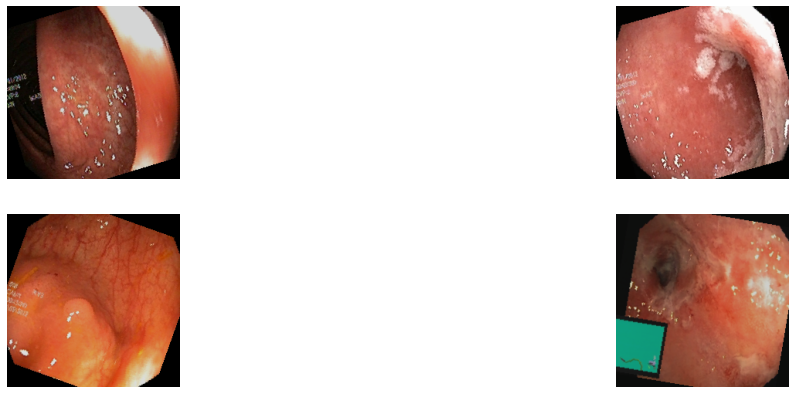

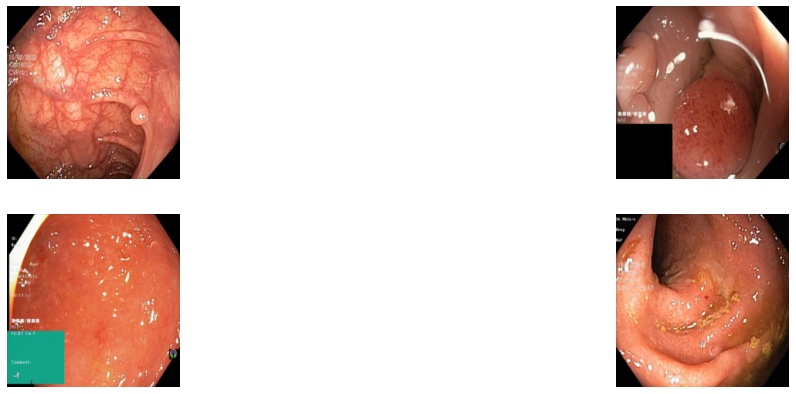

In [9]:
config = get_config('./configs/local_supervised.yaml')
df_anno = pd.read_csv(config['DATA']['ANNO'])
df_unanno = None
train_dl, valid_dl = get_data(config, df_anno, df_unanno, is_visual=True)
model = build_model(config, is_pathology = True)

### Semi-supervised Learning

In [10]:
# config = get_config('./configs/kaggle_semisupervised_real_1.yaml')
# df_anno = pd.read_csv(config['DATA']['ANNO'])
# df_unanno = pd.read_csv(config['DATA']['UNANNO'])
# train_dl, valid_dl = get_data(config, 
#                               df_anno, 
#                               df_unanno, 
#                               is_full_sup = False, 
#                               is_visual=True, 
#                               type_semi = config.MODEL.TYPE_SEMI)

# model = build_model(config, is_pathology = True)

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:
if config.TRAIN.IS_SSL:
    if config.MODEL.TYPE_SEMI == 'FixMatch':
        classifier = FixMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
    elif config.MODEL.TYPE_SEMI == 'CoMatch':
        classifier = CoMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
    elif config.MODEL.TYPE_SEMI == 'SemiFormer':
        classifier = SemiFormer(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
else:
    classifier = SupLearning(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
    
classifier.get_dataloader(train_dl, valid_dl)
classifier.get_config(config)

Training mode: Supervised Learning


In [13]:
# classifier.fit()

In [14]:
# classifier.save_checkpoint('/kaggle/working/')

In [15]:
classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\sup_densenet161\\06_27_2022_16_03_56_epoch_35_6_pathos_adam.pth')

100%|██████████████████████████████████████████████████| 16/16 [03:30<00:00, 13.15s/it, loss=0.378]


Metric:
{'micro/precision': 0.8306122448979592, 'micro/recall': 0.8306122448979592, 'micro/f1': 0.8306122448979592, 'macro/precision': 0.7678005867099656, 'macro/recall': 0.78462906931562, 'macro/f1': 0.7659639878716576, 'sen/spec':    class  sensitivity  specificity
0      0     1.000000     0.965686
1      1     0.959900     0.582418
2      2     0.957041     0.901408
3      3     0.984018     0.673077
4      4     0.925843     0.844444
5      5     0.980562     0.740741}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       204
           1       0.77      0.58      0.66        91
           2       0.78      0.90      0.84        71
           3       0.83      0.67      0.74        52
           4       0.54      0.84      0.66        45
           5       0.69      0.74      0.71        27

    accuracy                           0.83       490
   macro avg       0.77      0.78      0.77       490
weighted a

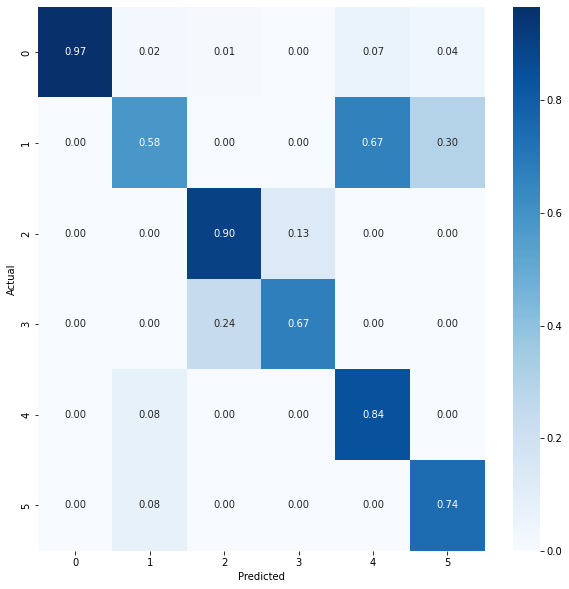

In [16]:
idxs_mask = classifier.evaluate_one(True, True, True)

In [30]:
valid_dl.dataset.df['Miscls'] = idxs_mask.numpy().tolist()
valid_dl.dataset.df['Miscls'].value_counts()

C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


False    407
True      83
Name: Miscls, dtype: int64

In [46]:
df_valid = valid_dl.dataset.df
df_valid.head()

,index,image,is_valid,target,Miscls
1978,3050,lower-gi-tract/pathological-findings/polyps/dc...,True,0,False
1979,5461,lower-gi-tract/pathological-findings/polyps/f8...,True,0,False
1980,8895,lower-gi-tract/pathological-findings/ulcerativ...,True,1,False
1981,8464,lower-gi-tract/pathological-findings/ulcerativ...,True,1,False
1982,6077,lower-gi-tract/pathological-findings/polyps/ca...,True,0,False


In [47]:
list_imgs_miscls = df_valid[df_valid['Miscls']==True]['image']
list_imgs_miscls = [os.path.join(config.DATA.PATH, item) for item in list_imgs_miscls]

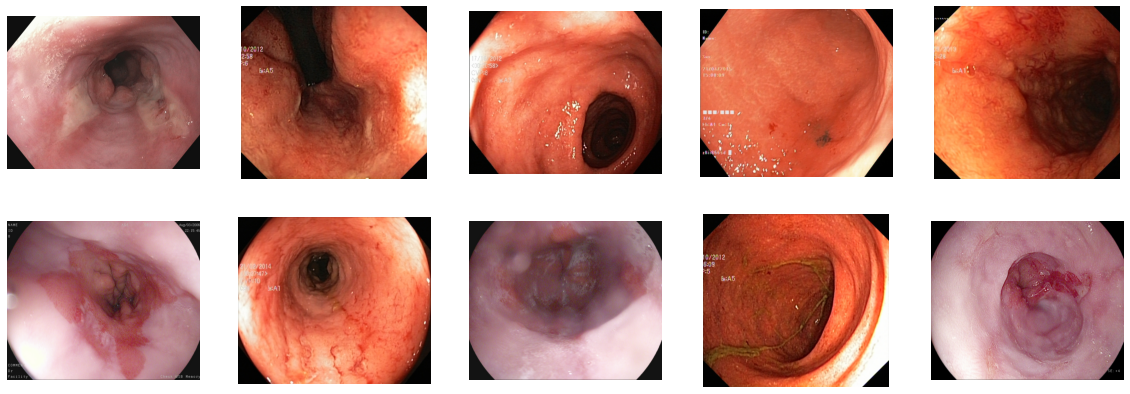

In [54]:
show_imgs(list_imgs_miscls[:10])

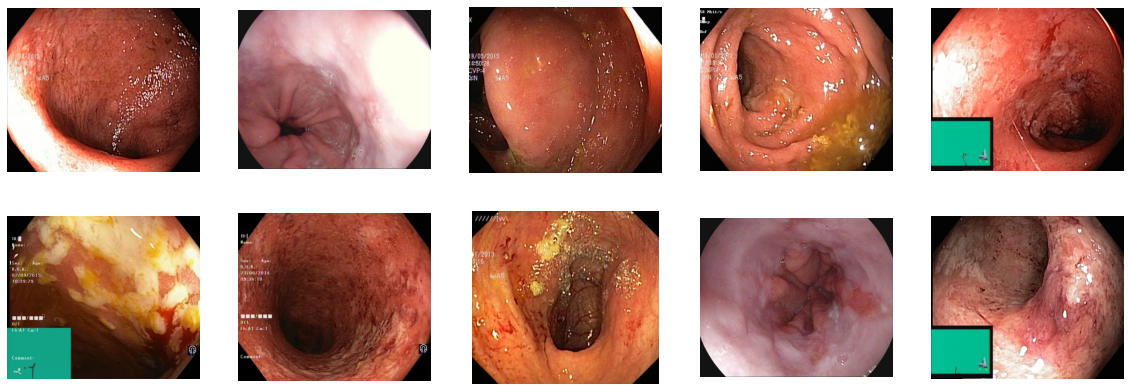

In [55]:
show_imgs(list_imgs_miscls[10:20])

In [18]:
# df_unanno['pred'] = list(out_pred)
# df_unanno['pred'].value_counts()

In [19]:
# df_unanno.to_csv("/kaggle/working/full_unlabeled_predict.csv", header =True, index = False)

In [20]:
# classifier.fit()

In [21]:
# classifier.save_checkpoint('/kaggle/working/')

In [22]:
# classifier.load_checkpoint('/kaggle/working/06_29_2022_10_33_55_epoch_20.pth')

In [23]:
# classifier.evaluate_one(True, True, True)